In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn import preprocessing
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose

In [144]:
def error(y_pred, y_true):
    return (np.abs(y_pred - y_true)) / y_pred

In [7]:
df = pd.read_csv('train_data.csv')
df

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...
...,...,...,...,...,...,...,...,...,...,...,...,...
8526521,1565978400,30.324878,59.932612,48,0,15,2,0,0,0,1,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526522,1565978400,30.324878,59.932612,20,1,0,0,0,0,0,0,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526523,1565978400,30.324878,59.932612,54,2,75,7,0,0,0,6,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526524,1565971200,30.324878,59.932612,15,0,350,4,25,0,0,0,0101000020E61000005DECCB372B533E40494A4ED65FF7...


In [8]:
# сократим количество потребляемой оперативы
df = df[['timestamp', 'point']]
df

,timestamp,point
0,1565607600,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,0101000020E6100000268147F5244F3E40494A4ED65FF7...
...,...,...
8526521,1565978400,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526522,1565978400,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526523,1565978400,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526524,1565971200,0101000020E61000005DECCB372B533E40494A4ED65FF7...


In [9]:
len(df.point.unique())

7041

In [50]:
# validation contains 710 cubes
# February 2020
valid_df = pd.read_csv('valid.csv')
valid_df = valid_df[['point', 'hour', 'sum', 'error']]
valid_df['timestamp']= [datetime.fromtimestamp(x) for x in valid_df['hour']]
valid_df['Dates'] = pd.to_datetime(valid_df['timestamp']).dt.date
valid_df['Time'] = pd.to_datetime(valid_df['timestamp']).dt.time
valid_df.sort_values(by=['sum'], ascending=False)

,point,hour,sum,error,timestamp,Dates,Time
504,0101000020E610000091029C327E593E40494A4ED65FF7...,1580587200,40,38.754735,2020-02-01 23:00:00,2020-02-01,23:00:00
638,0101000020E61000004D98FA185E5C3E40D4F7F058CCF6...,1582560000,39,3.629735,2020-02-24 19:00:00,2020-02-24,19:00:00
100,0101000020E6100000A4566D514B503E4006FC5DE561F8...,1581094800,38,17.754735,2020-02-07 20:00:00,2020-02-07,20:00:00
529,0101000020E6100000A4566D514B503E4006FC5DE561F8...,1580835600,38,36.754735,2020-02-04 20:00:00,2020-02-04,20:00:00
234,0101000020E6100000669634C7914E3E407AB3D8B484F7...,1581019200,37,4.921402,2020-02-06 23:00:00,2020-02-06,23:00:00
...,...,...,...,...,...,...,...
79,0101000020E61000000FD8C18EA45A3E408991431816F7...,1580666400,5,0.245265,2020-02-02 21:00:00,2020-02-02,21:00:00
506,0101000020E6100000268147F5244F3E40DB251193A9F7...,1581001200,5,3.754735,2020-02-06 18:00:00,2020-02-06,18:00:00
507,0101000020E61000006141807FDE503E402B348A98ADF9...,1580785200,5,3.754735,2020-02-04 06:00:00,2020-02-04,06:00:00
510,0101000020E61000004D98FA185E5C3E40CAE971F73AF7...,1580882400,5,0.004735,2020-02-05 09:00:00,2020-02-05,09:00:00


In [11]:
len(valid_df.point.unique())

155

In [12]:
true_point = sorted(valid_df.point.unique())
true_point

['0101000020E610000000000000000000000000000000000000',
 '0101000020E61000000C830D47F15C3E400A41C338F1F64D40',
 '0101000020E61000000C830D47F15C3E40CAE971F73AF74D40',
 '0101000020E61000000FD8C18EA45A3E408991431816F74D40',
 '0101000020E61000000FD8C18EA45A3E40CAE971F73AF74D40',
 '0101000020E6100000132D76D657583E408991431816F74D40',
 '0101000020E61000001868CE7F1F343E40975BBA5723FE4D40',
 '0101000020E6100000199C86BCF6773E401FBF4913EFF54D40',
 '0101000020E6100000199C86BCF6773E406A1274D638F64D40',
 '0101000020E61000001CD7DE65BE533E40A554BF083DF84D40',
 '0101000020E61000002012370F862F3E40A08C1570AEEA4D40',
 '0101000020E6100000202C93AD71513E4009249E9F54F24D40',
 '0101000020E6100000202C93AD71513E401E66D608FBFB4D40',
 '0101000020E6100000202C93AD71513E4041010E3DD6EB4D40',
 '0101000020E6100000202C93AD71513E4054F844A221FD4D40',
 '0101000020E6100000202C93AD71513E4070B5CC78A7F64D40',
 '0101000020E6100000202C93AD71513E407A441D895BF54D40',
 '0101000020E6100000202C93AD71513E40CEB8CE2B18F84D40',
 '01010000

In [13]:
# Оставим в датасете только интересующие нас кубы и переведем timestamp в даты
df['timestamp']= [datetime.fromtimestamp(x) for x in df['timestamp']]
df_clear = df[df.point.isin(true_point)]
df_clear

C:\Users\gto_n\AppData\Local\Temp\ipykernel_30532\1137194191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp']= [datetime.fromtimestamp(x) for x in df['timestamp']]


,timestamp,point
0,2019-08-12 14:00:00,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,2019-08-12 03:00:00,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,2019-08-12 03:00:00,0101000020E61000009E01B90998523E40888919D70805...
3,2019-08-12 03:00:00,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,2019-08-12 03:00:00,0101000020E6100000268147F5244F3E40494A4ED65FF7...
...,...,...
8526521,2019-08-16 21:00:00,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526522,2019-08-16 21:00:00,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526523,2019-08-16 21:00:00,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526524,2019-08-16 19:00:00,0101000020E61000005DECCB372B533E40494A4ED65FF7...


In [14]:
df_clear

,timestamp,point
0,2019-08-12 14:00:00,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,2019-08-12 03:00:00,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,2019-08-12 03:00:00,0101000020E61000009E01B90998523E40888919D70805...
3,2019-08-12 03:00:00,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,2019-08-12 03:00:00,0101000020E6100000268147F5244F3E40494A4ED65FF7...
...,...,...
8526521,2019-08-16 21:00:00,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526522,2019-08-16 21:00:00,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526523,2019-08-16 21:00:00,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526524,2019-08-16 19:00:00,0101000020E61000005DECCB372B533E40494A4ED65FF7...


In [37]:

working_df = df_clear.groupby(['point', 'timestamp']).size().reset_index(name='counts')
working_df.sort_values(by=['counts'], ascending=False)

,point,timestamp,counts
229619,0101000020E61000004D98FA185E5C3E40CAE971F73AF7...,2020-01-20 02:00:00,329
309069,0101000020E61000006141807FDE503E402B348A98ADF9...,2019-05-09 22:00:00,253
43153,0101000020E6100000199C86BCF6773E401FBF4913EFF5...,2019-02-05 00:00:00,248
309070,0101000020E61000006141807FDE503E402B348A98ADF9...,2019-05-09 23:00:00,230
327447,0101000020E61000006141807FDE503E408F0FCDBE88F9...,2020-01-19 20:00:00,200
...,...,...,...
657347,0101000020E6100000BE54A7FF7E423E40F91CC68469FC...,2019-12-11 14:00:00,1
657346,0101000020E6100000BE54A7FF7E423E40F91CC68469FC...,2019-12-11 11:00:00,1
657345,0101000020E6100000BE54A7FF7E423E40F91CC68469FC...,2019-12-11 08:00:00,1
657344,0101000020E6100000BE54A7FF7E423E40F91CC68469FC...,2019-12-11 02:00:00,1


In [16]:
working_df = df_clear.groupby(['point','timestamp']).size().unstack(fill_value=
                                                         0
                                                         ).stack()
working_df = working_df.reset_index(name='counts')
working_df

,point,timestamp,counts
0,0101000020E61000000000000000000000000000000000...,2019-01-01 03:00:00,3
1,0101000020E61000000000000000000000000000000000...,2019-01-01 04:00:00,2
2,0101000020E61000000000000000000000000000000000...,2019-01-01 05:00:00,2
3,0101000020E61000000000000000000000000000000000...,2019-01-01 06:00:00,0
4,0101000020E61000000000000000000000000000000000...,2019-01-01 07:00:00,0
...,...,...,...
1473115,0101000020E6100000F92E3C2824663E40134E7A739601...,2020-01-31 22:00:00,1
1473116,0101000020E6100000F92E3C2824663E40134E7A739601...,2020-01-31 23:00:00,0
1473117,0101000020E6100000F92E3C2824663E40134E7A739601...,2020-02-01 00:00:00,2
1473118,0101000020E6100000F92E3C2824663E40134E7A739601...,2020-02-01 01:00:00,0


In [17]:
# Разделим timestamp на дату и время
working_df['Dates'] = pd.to_datetime(working_df['timestamp']).dt.date
working_df['Time'] = pd.to_datetime(working_df['timestamp']).dt.time
working_df

,point,timestamp,counts,Dates,Time
0,0101000020E61000000000000000000000000000000000...,2019-01-01 03:00:00,3,2019-01-01,03:00:00
1,0101000020E61000000000000000000000000000000000...,2019-01-01 04:00:00,2,2019-01-01,04:00:00
2,0101000020E61000000000000000000000000000000000...,2019-01-01 05:00:00,2,2019-01-01,05:00:00
3,0101000020E61000000000000000000000000000000000...,2019-01-01 06:00:00,0,2019-01-01,06:00:00
4,0101000020E61000000000000000000000000000000000...,2019-01-01 07:00:00,0,2019-01-01,07:00:00
...,...,...,...,...,...
1473115,0101000020E6100000F92E3C2824663E40134E7A739601...,2020-01-31 22:00:00,1,2020-01-31,22:00:00
1473116,0101000020E6100000F92E3C2824663E40134E7A739601...,2020-01-31 23:00:00,0,2020-01-31,23:00:00
1473117,0101000020E6100000F92E3C2824663E40134E7A739601...,2020-02-01 00:00:00,2,2020-02-01,00:00:00
1473118,0101000020E6100000F92E3C2824663E40134E7A739601...,2020-02-01 01:00:00,0,2020-02-01,01:00:00


In [18]:
working_df.timestamp.unique()

array(['2019-01-01T03:00:00.000000000', '2019-01-01T04:00:00.000000000',
       '2019-01-01T05:00:00.000000000', ...,
       '2020-02-01T00:00:00.000000000', '2020-02-01T01:00:00.000000000',
       '2020-02-01T02:00:00.000000000'], dtype='datetime64[ns]')

In [19]:
points = working_df.point.unique()
points

array(['0101000020E610000000000000000000000000000000000000',
       '0101000020E61000000C830D47F15C3E400A41C338F1F64D40',
       '0101000020E61000000C830D47F15C3E40CAE971F73AF74D40',
       '0101000020E61000000FD8C18EA45A3E408991431816F74D40',
       '0101000020E61000000FD8C18EA45A3E40CAE971F73AF74D40',
       '0101000020E6100000132D76D657583E408991431816F74D40',
       '0101000020E61000001868CE7F1F343E40975BBA5723FE4D40',
       '0101000020E6100000199C86BCF6773E401FBF4913EFF54D40',
       '0101000020E6100000199C86BCF6773E406A1274D638F64D40',
       '0101000020E61000001CD7DE65BE533E40A554BF083DF84D40',
       '0101000020E61000002012370F862F3E40A08C1570AEEA4D40',
       '0101000020E6100000202C93AD71513E4009249E9F54F24D40',
       '0101000020E6100000202C93AD71513E401E66D608FBFB4D40',
       '0101000020E6100000202C93AD71513E4041010E3DD6EB4D40',
       '0101000020E6100000202C93AD71513E4054F844A221FD4D40',
       '0101000020E6100000202C93AD71513E4070B5CC78A7F64D40',
       '0101000020E61000

In [20]:
len(points)

155

In [51]:
example_train = working_df[working_df.point == points[0]]
example_train

,point,timestamp,counts
0,0101000020E61000000000000000000000000000000000...,2019-01-01 03:00:00,3
1,0101000020E61000000000000000000000000000000000...,2019-01-01 04:00:00,2
2,0101000020E61000000000000000000000000000000000...,2019-01-01 05:00:00,2
3,0101000020E61000000000000000000000000000000000...,2019-01-01 08:00:00,3
4,0101000020E61000000000000000000000000000000000...,2019-01-01 09:00:00,2
...,...,...,...
8465,0101000020E61000000000000000000000000000000000...,2020-01-31 21:00:00,10
8466,0101000020E61000000000000000000000000000000000...,2020-01-31 22:00:00,8
8467,0101000020E61000000000000000000000000000000000...,2020-01-31 23:00:00,13
8468,0101000020E61000000000000000000000000000000000...,2020-02-01 00:00:00,13


In [55]:
example_test = valid_df[valid_df.point == points[0]]
example_test.sort_values(by=['timestamp'], inplace=True)
example_test

C:\Users\gto_n\AppData\Local\Temp\ipykernel_30532\493079775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_test.sort_values(by=['timestamp'], inplace=True)


,point,hour,sum,error,timestamp,Dates,Time
480,0101000020E61000000000000000000000000000000000...,1580799600,10,0.754735,2020-02-04 10:00:00,2020-02-04,10:00:00
538,0101000020E61000000000000000000000000000000000...,1580821200,14,1.465399,2020-02-04 16:00:00,2020-02-04,16:00:00
424,0101000020E61000000000000000000000000000000000...,1580907600,12,0.088069,2020-02-05 16:00:00,2020-02-05,16:00:00
52,0101000020E61000000000000000000000000000000000...,1580936400,6,1.865399,2020-02-06 00:00:00,2020-02-06,00:00:00
540,0101000020E61000000000000000000000000000000000...,1581156000,5,0.620265,2020-02-08 13:00:00,2020-02-08,13:00:00
597,0101000020E61000000000000000000000000000000000...,1581159600,8,0.088069,2020-02-08 14:00:00,2020-02-08,14:00:00
641,0101000020E61000000000000000000000000000000000...,1581174000,15,0.629735,2020-02-08 18:00:00,2020-02-08,18:00:00
618,0101000020E61000000000000000000000000000000000...,1581346800,12,1.608256,2020-02-10 18:00:00,2020-02-10,18:00:00
368,0101000020E61000000000000000000000000000000000...,1581595200,10,0.004735,2020-02-13 15:00:00,2020-02-13,15:00:00
668,0101000020E61000000000000000000000000000000000...,1581696000,8,1.798732,2020-02-14 19:00:00,2020-02-14,19:00:00


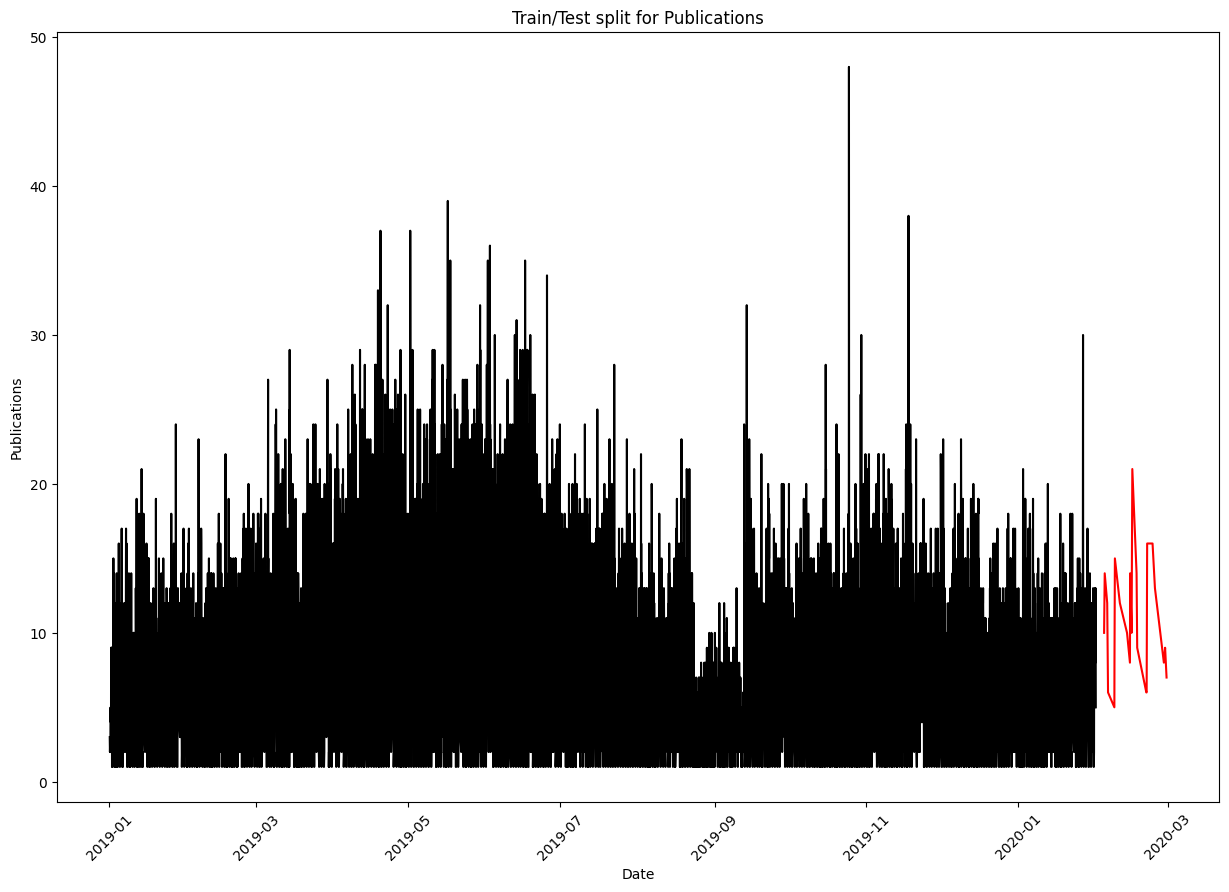

In [56]:
fig = plt.figure(figsize=(15, 10))
plt.plot(example_train['timestamp'],example_train['counts'] , color = "black")
plt.plot(example_test['timestamp'],example_test['sum'], color = "red")
plt.ylabel('Publications')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Publications")
plt.savefig('S.jpg', bbox_inches='tight')
plt.show()

In [61]:
train_df = example_train[['timestamp', 'counts']][0:int(len(example_train)*0.9)]
val_df = example_train[['timestamp', 'counts']][int(len(example_train)*0.9):]
test_df = example_test[['timestamp', 'sum']]
num_features = train_df.shape[1] - 1
num_features

1

In [110]:
example_test

,point,hour,sum,error,timestamp,Dates,Time
480,0101000020E61000000000000000000000000000000000...,1580799600,10,0.754735,2020-02-04 10:00:00,2020-02-04,10:00:00
538,0101000020E61000000000000000000000000000000000...,1580821200,14,1.465399,2020-02-04 16:00:00,2020-02-04,16:00:00
424,0101000020E61000000000000000000000000000000000...,1580907600,12,0.088069,2020-02-05 16:00:00,2020-02-05,16:00:00
52,0101000020E61000000000000000000000000000000000...,1580936400,6,1.865399,2020-02-06 00:00:00,2020-02-06,00:00:00
540,0101000020E61000000000000000000000000000000000...,1581156000,5,0.620265,2020-02-08 13:00:00,2020-02-08,13:00:00
597,0101000020E61000000000000000000000000000000000...,1581159600,8,0.088069,2020-02-08 14:00:00,2020-02-08,14:00:00
641,0101000020E61000000000000000000000000000000000...,1581174000,15,0.629735,2020-02-08 18:00:00,2020-02-08,18:00:00
618,0101000020E61000000000000000000000000000000000...,1581346800,12,1.608256,2020-02-10 18:00:00,2020-02-10,18:00:00
368,0101000020E61000000000000000000000000000000000...,1581595200,10,0.004735,2020-02-13 15:00:00,2020-02-13,15:00:00
668,0101000020E61000000000000000000000000000000000...,1581696000,8,1.798732,2020-02-14 19:00:00,2020-02-14,19:00:00


In [102]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(example_train['counts'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -5.779024013649634
p-value: 5.17787494265096e-07
Critical Values:
	1%: -3.431125493913209
	5%: -2.861882715177107
	10%: -2.566952422408677


In [118]:
model = ARIMA(example_train.counts, order=(1,1,1))
results = model.fit()
results.predict(start=example_test.iloc[0].index, end=example_test.iloc[-1].index, dynamic=False)

C:\Users\gto_n\anaconda3\envs\PycharmProjects\lib\site-packages\pandas\core\indexes\base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [123]:
train_df['timestamp']=pd.to_datetime(train_df['timestamp'])
train_df

,timestamp,counts
0,2019-01-01 03:00:00,3
1,2019-01-01 04:00:00,2
2,2019-01-01 05:00:00,2
3,2019-01-01 08:00:00,3
4,2019-01-01 09:00:00,2
...,...,...
7618,2019-12-24 11:00:00,5
7619,2019-12-24 12:00:00,2
7620,2019-12-24 13:00:00,13
7621,2019-12-24 14:00:00,4


In [126]:
import pmdarima
best_model = pmdarima.auto_arima(train_df['counts'],
                                 m=12, seasonal=True,
                                 start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True, trace=True)
print("best model --> (p, d, q):", best_model.order, " and  (P, D,Q, s):", best_model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=48560.961, Time=6.19 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=49264.203, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=44419.866, Time=2.41 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=46439.019, Time=2.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=58062.588, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=44434.517, Time=0.24 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=44305.559, Time=8.32 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=44292.100, Time=21.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=44359.350, Time=6.85 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=33.11 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=44287.620, Time=18.76 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=44321.581, Time=9.24 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=44422.913, Time=8.71 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=47416.593, Time=12.43 sec
 ARIMA(

In [131]:
best_model.fit(train_df['counts'])

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

In [142]:
forecast=best_model.predict(n_periods=int(val_df.counts.size), return_conf_int=False)
forecast

7623    10.388064
7624     9.787628
7625     9.215127
7626    10.182711
7627    10.050049
          ...    
8465     9.080248
8466     9.080248
8467     9.080248
8468     9.080248
8469     9.080248
Length: 847, dtype: float64

In [146]:
np.mean(error(forecast, val_df.counts))

0.43851562195515176

ValueError: x and y must have same first dimension, but have shapes (23,) and (8447,)

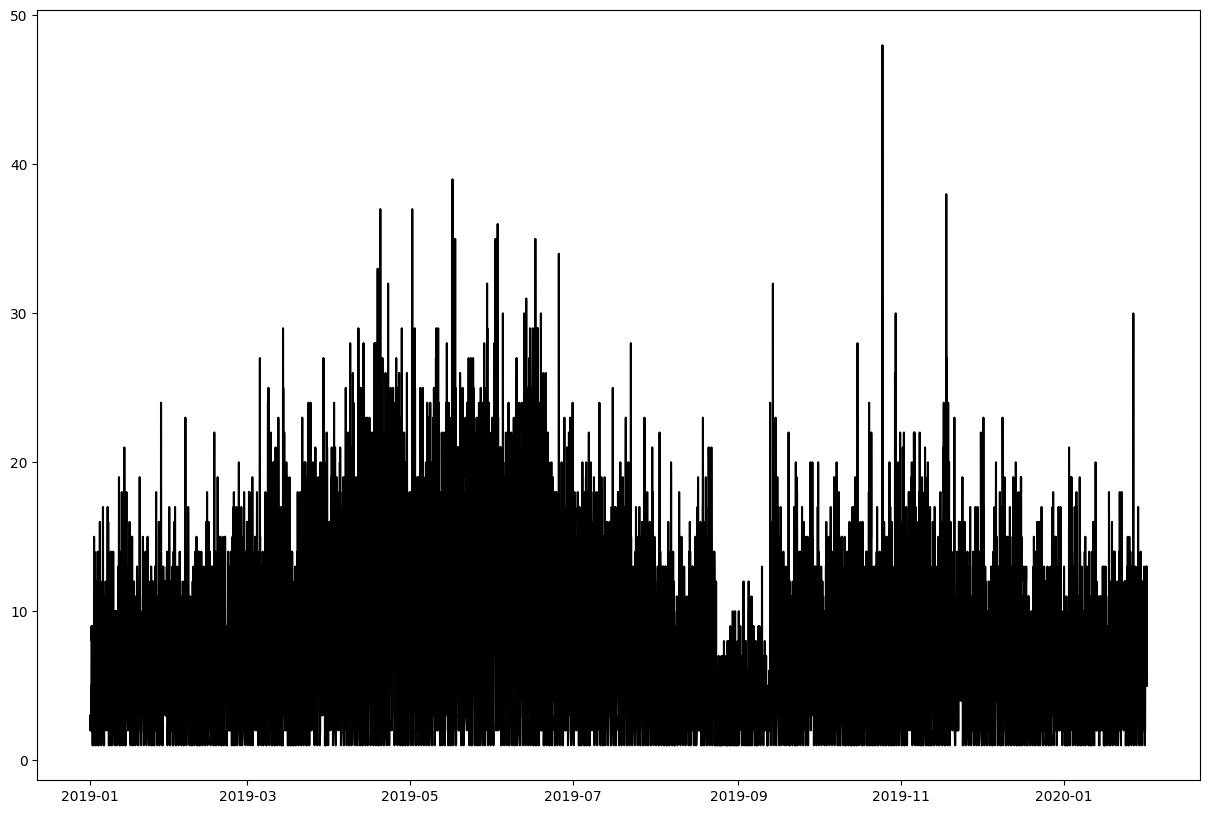

In [81]:
fig = plt.figure(figsize=(15, 10))
plt.plot(example_train['timestamp'],example_train['counts'] , color = "black")
plt.plot(example_test['timestamp'],y_pred, color = "red")
plt.ylabel('Publications')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Publications")
plt.savefig('S.jpg', bbox_inches='tight')
plt.show()